In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from DDBSCAN import Raster_DBSCAN
import matplotlib.colors as mcolors
import cv2
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
import seaborn as sns
# times new roman font
plt.rcParams["font.family"] = "Times New Roman"
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

In [2]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
lane_unit = 200
time_span = 100
hidden_size = 256
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\models\train_2"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_16.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[7,13],eps = 1,min_samples=3)

In [4]:
connection_pairs = [(0,1),(1,2),(2,3),(5,6)]
# identify chains in the connection_pairs and return the chain list
def identify_chains(connection_pairs):
    chains = []
    for pair in connection_pairs:
        if len(chains) == 0:
            chains.append(list(pair))
        else:
            pair_inserted = False
            for chain in chains:
                if pair[0] in chain:
                    chain.append(pair[1])
                    pair_inserted = True
                    break
                elif pair[1] in chain:
                    chain.append(pair[0])
                    pair_inserted = True
                    break
            if not pair_inserted:
                chains.append(list(pair))
    return chains
connection_pairs_ = identify_chains(connection_pairs)

In [30]:
def get_traj_labels(traj_dir,trajectory,time_space_diagram):
    # read labels in txt file in keypoint format for yolov8 and extract the keypoint coordinates
    lines = []
    with open(os.path.join(traj_dir,trajectory),'r') as f:
        for line in f:
            line = line.strip().split()
            line = [float(i) for i in line]
            lines.append(line)
    lines = np.array(lines)
    trajs_label = []
    # from index 8 of each row is the keypoint coordinates: something, x,y , something, x,y ...
    for line in lines:
        coords = []
        for i in range(5,len(line),3):
            coords.append((line[i],line[i+1]))
        coords = np.array(coords)
        coords[:,0] *= time_space_diagram.shape[1]
        coords[:,1] *= time_space_diagram.shape[0]
        traj = coords[coords[:,0].argsort()]
        trajs_label.append(traj)
    return trajs_label

def get_trajctories_dict_from_Label_map(Labels,time_span,center = True):
    trajectories_output = defaultdict(list)
    for t in range(time_span):
        Labels_t = Labels[:,t]
        unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
        if center:
            center_locations = xs + 0.5*counts
        else:
            center_locations = xs
        if unique_id[0] == -1:
            unique_id = unique_id[1:]
            center_locations = center_locations[1:]
        for i, label in enumerate(unique_id):
            trajectories_output[label].append((t,center_locations[i]))
    for key in trajectories_output.keys():
        traj = trajectories_output[key]
        trajectories_output[key] = np.array(traj)
    return trajectories_output

def get_trajs_from_LSTM_out(time_space_diagram,conf_thred = 0.35,time_span = 100, lane_unit = 200,center = True):
    pred_trajectories = time_space_diagram > conf_thred
    Labels = db.fit_predict(pred_trajectories, pred_trajectories)
    num_lane_units, time_span = time_space_diagram.shape
    trajectories_output = get_trajctories_dict_from_Label_map(Labels,time_span,center)
    # convert to list
    trajectories_output_ = []
    for key in trajectories_output.keys():
        traj = trajectories_output[key]
        trajectories_output_.append(traj)
    return trajectories_output_

def get_trajs_from_Kalman_out(time_space_diagram_input,time_span = 100):
    Labels = db.fit_predict(time_space_diagram_input> 0, time_space_diagram_input > 0)
    trajs_pred = get_trajctories_dict_from_Label_map(Labels,time_span,center = False)
    future_time_span = 25 # for kalmann filter
    connection_pairs = []
    for key in trajs_pred.keys():
        traj = np.array(trajs_pred[key])
        xs = traj[:,1]
        ts = traj[:,0]
        # interpolate the trajectory
        interpfunc = interp1d(ts, xs, kind='linear')
        ts = np.arange(ts[0],ts[-1]+1)
        xs = interpfunc(ts)

        f = KalmanFilter(dim_x=2, dim_z=1)
        f.x = np.array([[xs[0]],  # position
                        [0.]]) # velocity
        f.F = np.array([[1.,1.],
                        [0.,1.]])
        f.H = np.array([[1.,0.]])
        f.P *= 1000.
        f.R = 30000
        f.Q = 1
        kalman_traj = [xs[0]]
        kalman_traj_future = []
        for t in range(1,len(ts)):
            f.predict()
            f.update(xs[t])
            kalman_traj.append(f.x[0][0])

        find_connection_flag = False
        for t in range(len(ts),len(ts)+future_time_span):
            f.predict()
            
            for key_ in trajs_pred.keys():
                if key_ == key:
                    continue
                x_residual = np.abs(f.x[0][0] - trajs_pred[key_][0,1])
                t_residual =  trajs_pred[key_][0,0] - t 
                if x_residual < 2 and t_residual < 5 and t_residual > 0:
                    connection_pairs.append((key,key_))
                    find_connection_flag = True
                    break
            if find_connection_flag:
                break
    trajs_pred_ = trajs_pred.copy()
    connection_pairs_ = identify_chains(connection_pairs)
    for chain in connection_pairs_:
        for i in range(1,len(chain)):
            try:
                trajs_pred_[chain[0]] = np.concatenate([trajs_pred_[chain[0]],trajs_pred_[chain[i]]],axis = 0)
                trajs_pred_.pop(chain[i])
            except:
                continue
    trajs_pred_ = [trajs_pred_[key] for key in trajs_pred_.keys()]
    return trajs_pred_

# evaluate 
speed_eva_window = 5
def get_traj_errors(trajs_label,trajs_pred,speed_eva_window = 5):
    speed_errors = []
    location_errors = []
    for i, traj_label in enumerate(trajs_label):
        for j, traj_pred in enumerate(trajs_pred.values()):
            if len(traj_pred) < speed_eva_window:
                continue
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            x_label_interp = interp_func(t_pred)
            
            # get the overlapping time span
            t_label_max,t_label_min = t_label[-1],t_label[0]
            t_pred_max,t_pred_min = t_pred[-1],t_pred[0]
            # if two trajectories have overlapping time span

            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            overlap_start = max(t_pred_min,t_label_min)
            overlap_end = min(t_pred_max,t_label_max)
            x_label_interp_overlap = x_label_interp[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
            x_pred_overlap = x_pred[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
            # Calculate residuals
            residuals = x_pred_overlap - x_label_interp_overlap
            if len(residuals) == 0:
                continue
            location_error = np.mean(np.abs(residuals)) * 0.5 # meters
            
            if location_error < 1: # they are the same trajectory
      
                location_errors.append(location_error)            

                # calculate speed error
                speed_pred_curve = []
                speed_label_curve = []
                for k in range(len(residuals)-speed_eva_window):
                    speed_pred = (x_pred_overlap[k+speed_eva_window] - x_pred_overlap[k])*0.5 / (speed_eva_window/10)
                    speed_label = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
                    speed_pred_curve.append(speed_pred)
                    speed_label_curve.append(speed_label)
                speed_pred_curve = np.array(speed_pred_curve)
                speed_label_curve = np.array(speed_label_curve)
                if len(speed_pred_curve) == 0:
                    continue
                speed_error = np.mean(np.abs(speed_pred_curve - speed_label_curve)) # m/s
                if speed_error > 4:
                    print(location_error,speed_error, i,j)
                    plt.plot(x_label_interp_overlap,'b')
                    plt.plot(x_pred_overlap,'r')
                    plt.show()
                speed_errors.append(speed_error)
    return location_errors, speed_errors

def get_interpolated_traj(traj_label,traj_pred):
    t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
    # drop duplicate time points
    t_pred, indices = np.unique(t_pred, return_index=True)
    x_pred = x_pred[indices]
    t_label, x_label = traj_label[:, 0], traj_label[:, 1]
    # drop duplicate time points
    t_label, indices = np.unique(t_label, return_index=True)
    x_label = x_label[indices]
    # get the overlapping time span
    t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
    t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
   

    t_pred_ = np.arange(t_pred_min,t_pred_max+1)
    t_label_ = np.arange(t_label_min,t_label_max+1)
    # Interpolate label trajectory to match pred trajectory time points
    interp_func_label = interp1d(t_label, x_label, fill_value="extrapolate")
    interp_func_pred = interp1d(t_pred, x_pred, fill_value="extrapolate")
    x_label_interp = interp_func_label(t_pred_)
    x_pred_interp = interp_func_pred(t_label_)
    return t_pred_,t_label_,x_label_interp,x_pred_interp

def get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = 1):
    TrajIoUMatrix = np.zeros((len(trajs_label),len(trajs_pred)))
    TrajPortionMatrix = np.zeros((len(trajs_label),len(trajs_pred)))
    for i, traj_label in enumerate(trajs_label):
        for j, traj_pred in enumerate(trajs_pred):
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # get the overlapping time span
            t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
            t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
            # if two trajectories have no overlapping time span, skip
            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            t_pred_,t_label_,x_label_interp,x_pred_interp = get_interpolated_traj(traj_label,traj_pred)
            t_pred_ = np.arange(t_pred_min,t_pred_max+1)
            t_label_ = np.arange(t_label_min,t_label_max+1)
            # Interpolate label trajectory to match pred trajectory time points
            interp_func_label = interp1d(t_label, x_label, fill_value="extrapolate")
            interp_func_pred = interp1d(t_pred, x_pred, fill_value="extrapolate")
            x_label_interp = interp_func_label(t_pred_)
            x_pred_interp = interp_func_pred(t_label_)

            overlap_start = max(t_pred_min,t_label_min)
            overlap_end = min(t_pred_max,t_label_max)
            union_start = min(t_pred_min,t_label_min)
            union_end = max(t_pred_max,t_label_max)
            num_union = union_end - union_start + 1
            num_overlap = overlap_end - overlap_start + 1
            x_label_interp_overlap = x_label_interp[(t_pred_ >= overlap_start) & (t_pred_ <= overlap_end)]
            x_pred_interp_overlap = x_pred_interp[(t_label_ >= overlap_start) & (t_label_ <= overlap_end)]
            residuals = np.abs(x_label_interp_overlap - x_pred_interp_overlap)
            if len(residuals) == 0:
                continue
            # if residuals.max() > x_error_threshold:
            #     continue
            TrajIoUMatrix[i,j] = (residuals < x_error_threshold).sum() / num_union
            # how long the pred trajectory is in the label trajectory
            TrajPortionMatrix[i,j] = (residuals < x_error_threshold).sum() / num_overlap

    return TrajIoUMatrix,TrajPortionMatrix

# Manual Dataset Evaluation

## LSTM Method

In [163]:
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
Iou_threshold = 0.8
total_tps, total_fps, total_fns = [], [], []
for conf_thred in np.arange(0.2,0.9,0.05):
    total_tp, total_fp, total_fn = 0, 0, 0
    for frame_ind in tqdm(range(len(time_space_diagram_list))):
        time_space_diagram_name = time_space_diagram_list[frame_ind]
        trajectory_name = trajectory_list[frame_ind]
        time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

        trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


        time_space_diagram_input = time_space_diagram_raw > 100
        time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
        original_shape = time_space_diagram_input.shape
        padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
        time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
        with torch.no_grad():
            input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
            input_snippet = input_snippet.unsqueeze(0)
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        output = output[:original_shape[0]]
        trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
        
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        if TrajIoUMatrix.shape[1] == 0:
            # no detection
            total_fn += len(trajs_label)
            continue
        pred_index = TrajPortionMatrix.argmax(axis = 1)
        pred_IoU = []
        for i,j in enumerate(pred_index):
            pred_IoU.append(TrajIoUMatrix[i,j])
        pred_IoU = np.array(pred_IoU)
        # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
        tp, fp, fn = 0, 0, 0
        for i,j in enumerate(pred_index):
            if pred_IoU[i] >= Iou_threshold:
                tp += 1
            else:
                fn += 1
        for j in range(len(trajs_pred)):
            if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
                continue
            if j not in pred_index:
                fp += 1
        # print(time_space_diagram_name)
        # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        total_tp += tp
        total_fp += fp
        total_fn += fn

    total_tps.append(total_tp)
    total_fps.append(total_fp)
    total_fns.append(total_fn)
df = pd.DataFrame({'ConfThred':np.arange(0.2,0.9,0.05),'TP':total_tps,'FP':total_fps,'FN':total_fns})
df['precision'] = df['TP'] / (df['TP'] + df['FP'])
df['recall'] = df['TP'] / (df['TP'] + df['FN'])
df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.csv',index = False)

100%|██████████| 109/109 [00:01<00:00, 62.29it/s]


In [31]:
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
Iou_threshold = 0.8
total_tp, total_fp, total_fn, total_id_switch, total_discontinuity = 0, 0, 0, 0,0
conf_thred = 0.35
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    original_shape = time_space_diagram_input.shape
    padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
    time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
    with torch.no_grad():
        input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    output = output[:original_shape[0]]
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    # if (TrajIoUMatrix > 0).sum(axis = 1).max() > 1 and (TrajIoUMatrix > 0).sum(axis = 0).max() > 1:
    #     break
    tp,fp,fn,id_switch,discontinuity = 0,0,0,0,0
    for i in range(TrajIoUMatrix.shape[0]):
        if (TrajPortionMatrix[i] > 0).sum() == 1:
            if TrajPortionMatrix[i].max() > Iou_threshold:
                tp += 1
            else:
                fn += 1
        if (TrajPortionMatrix[i] > 0).sum() > 1:
            discontinuity += 1
    for j in range(TrajIoUMatrix.shape[1]):
        if j not in pred_index and (TrajIoUMatrix[:,j] > 0).sum() > 1:
            id_switch += 1
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        if TrajPortionMatrix[i,j] > 0:
            pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    for j in range(TrajIoUMatrix.shape[1]):
        if j not in pred_index:
            fp += 1
    

    total_tp += tp
    total_fp += fp
    total_fn += fn
    total_id_switch += id_switch
    total_discontinuity += discontinuity

  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 109/109 [00:03<00:00, 32.60it/s]


In [32]:
total_tp,total_fp,total_fn,total_id_switch,total_discontinuity

(572, 90, 11, 3, 11)

In [ ]:
for i,j in enumerate(pred_index):
    if pred_IoU[i] >= Iou_threshold and len(trajs_pred[j]) > speed_eva_window:
        traj_label = trajs_label[i]
        traj_pred = trajs_pred[j]
        # Extract time and x values
        t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
        # drop duplicate time points
        t_pred, indices = np.unique(t_pred, return_index=True)
        x_pred = x_pred[indices]
        t_label, x_label = traj_label[:, 0], traj_label[:, 1]
        # drop duplicate time points
        t_label, indices = np.unique(t_label, return_index=True)
        x_label = x_label[indices]
        # get the overlapping time span
        t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
        t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
        # if two trajectories have no overlapping time span, skip
        if t_pred_max < t_label_min or t_pred_min > t_label_max:
            continue

        t_pred_ = np.arange(t_pred_min,t_pred_max+1)
        t_label_ = np.arange(t_label_min,t_label_max+1)
        # Interpolate label trajectory to match pred trajectory time points
        interp_func_label = interp1d(t_label, x_label, fill_value="extrapolate")
        interp_func_pred = interp1d(t_pred, x_pred, fill_value="extrapolate")
        x_label_interp = interp_func_label(t_pred_)
        x_pred_interp = interp_func_pred(t_label_)

        overlap_start = max(t_pred_min,t_label_min)
        overlap_end = min(t_pred_max,t_label_max)
        union_start = min(t_pred_min,t_label_min)
        union_end = max(t_pred_max,t_label_max)
        num_union = union_end - union_start + 1
        num_overlap = overlap_end - overlap_start + 1
        x_label_interp_overlap = x_label_interp[(t_pred_ >= overlap_start) & (t_pred_ <= overlap_end)]
        x_pred_interp_overlap = x_pred_interp[(t_label_ >= overlap_start) & (t_label_ <= overlap_end)]
        sptial_error = x_pred_interp_overlap - x_label_interp_overlap
        
        spatial_errors.append(sptial_error)
        # calculate speed error
        speed_pred_curve = []
        speed_label_curve = []
        for k in range(len(sptial_error)-speed_eva_window):
            speed_pred = (x_pred_interp_overlap[k+speed_eva_window] - x_pred_interp_overlap[k])*0.5 / (speed_eva_window/10)
            speed_label = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
            speed_pred_curve.append(speed_pred)
            speed_label_curve.append(speed_label)
        speed_pred_curve = np.array(speed_pred_curve)
        speed_label_curve = np.array(speed_label_curve)
        speed_error = speed_pred_curve - speed_label_curve
        speed_errors.append(speed_error)

In [25]:
total_tp,total_fp,total_fn,total_id_switch,total_discontinuity

(572, 90, 11, 3, 11)

In [165]:
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.csv',index = False)

In [166]:
acc_eva_df = pd.read_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.csv')

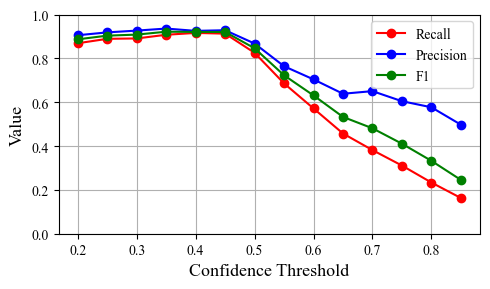

In [167]:
# plot precision recall curve and F1 score curve with different confidence threshold in same canvas, please make it beautiful
plt.figure(figsize=(5,3))
plt.grid()
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['recall'],label = 'Recall', color = 'r', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['precision'],label = 'Precision', color = 'b', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['F1'],label = 'F1', color = 'g', marker = 'o')
plt.xlabel('Confidence Threshold',fontsize = 13)
plt.ylabel('Value',fontsize = 13)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual_256.png',dpi = 300)
plt.show()

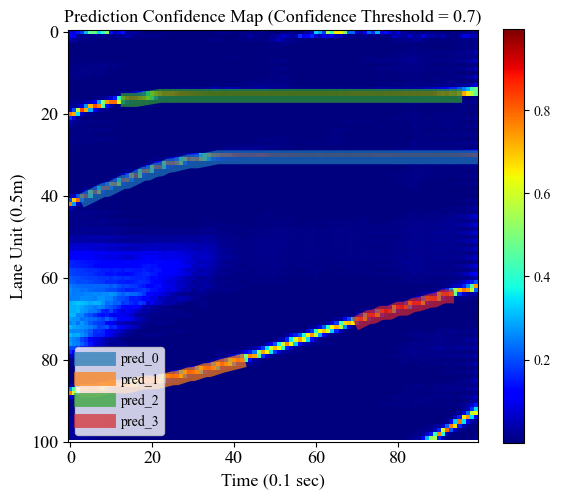

In [249]:
total_tp, total_fp, total_fn = 0, 0, 0
conf_thred = 0.8
frame_ind = 19
time_space_diagram_name = time_space_diagram_list[frame_ind]
trajectory_name = trajectory_list[frame_ind]
time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


time_space_diagram_input = time_space_diagram_raw > 100
time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
original_shape = time_space_diagram_input.shape
padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
with torch.no_grad():
    input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
    input_snippet = input_snippet.unsqueeze(0)
    output = best_model(input_snippet)
    output = output.squeeze(0).cpu().numpy()
output = output[:original_shape[0]]
trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)

plt.figure(figsize=(6,5))
plt.imshow(output,cmap='jet')
plt.title('Prediction Confidence Map (Confidence Threshold = 0.7)',fontsize = 13)
for i,traj in enumerate(trajs_pred):
    t, x = zip(*traj)
    if t[-1] - t[0] < 10:
        continue
    plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
plt.ylim(100)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Unit (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.colorbar()
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\pred_confidence_map_0.7.png',dpi = 300)
plt.show()


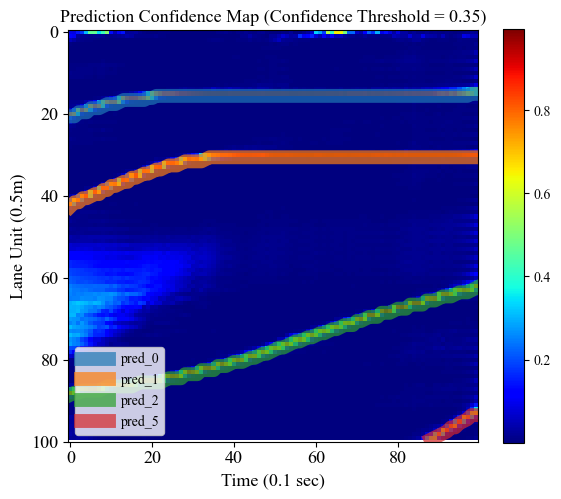

In [246]:
total_tp, total_fp, total_fn = 0, 0, 0
conf_thred = 0.35
frame_ind = 19

time_space_diagram_name = time_space_diagram_list[frame_ind]
trajectory_name = trajectory_list[frame_ind]
time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

time_space_diagram_input = time_space_diagram_raw > 100
time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
original_shape = time_space_diagram_input.shape
padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
with torch.no_grad():
    input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
    input_snippet = input_snippet.unsqueeze(0)
    output = best_model(input_snippet)
    output = output.squeeze(0).cpu().numpy()
output = output[:original_shape[0]]
trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)

plt.figure(figsize=(6,5))
plt.imshow(output,cmap='jet')
plt.title('Prediction Confidence Map (Confidence Threshold = 0.35)',fontsize = 13)
for i,traj in enumerate(trajs_pred):
    t, x = zip(*traj)
    if t[-1] - t[0] < 10:
        continue
    plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
plt.ylim(100)
plt.xlabel('Time (0.1 sec)',fontsize = 13)
plt.ylabel('Lane Unit (0.5m)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.colorbar()
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\pred_confidence_map_0.35.png',dpi = 300)
plt.show()


In [245]:
occlusion_figure_output = r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\Occlusion'
conf_thred = 0.35
for frame_ind in range(len(time_space_diagram_list)):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)

    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    original_shape = time_space_diagram_input.shape
    padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
    time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
    with torch.no_grad():
        input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    output = output[:original_shape[0]]
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)

    plt.figure(figsize=(6,5))
    plt.imshow(time_space_diagram_input,cmap='jet')
    # plt.title('Prediction Confidence Map (Confidence Threshold = 0.35)',fontsize = 13)
    for i,traj in enumerate(trajs_pred):
        t, x = zip(*traj)
        if t[-1] - t[0] < 10:
            continue
        plt.plot(t,x,label = f'pred_{i}', linewidth = 10,alpha = 0.7)
    plt.ylim(100)
    plt.xlabel('Time (0.1 sec)',fontsize = 13)
    plt.ylabel('Lane Unit (0.5m)',fontsize = 13)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.colorbar()
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.savefig(os.path.join(occlusion_figure_output,f'{frame_ind}.png'),dpi = 300)
    plt.close()
    # plt.show()


In [231]:
# get vehicle number and speed in time_space_diagram_list
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 3
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
spatial_errors = []
speed_errors = []
speed_eva_window = 10
conf_thred = 0.35
Iou_threshold = 0.95
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    original_shape = time_space_diagram_input.shape
    padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
    time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
    with torch.no_grad():
        input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
    output = output[:original_shape[0]]
    trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center= True)
    trajs_label = get_traj_labels(traj_dir,trajectory_list[frame_ind],time_space_diagram_raw)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold and len(trajs_pred[j]) > speed_eva_window:
            traj_label = trajs_label[i]
            traj_pred = trajs_pred[j]
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # drop duplicate time points
            t_label, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # get the overlapping time span
            t_label_max,t_label_min = int(t_label.max()),int(t_label.min())
            t_pred_max,t_pred_min = int(t_pred.max()),int(t_pred.min())
            # if two trajectories have no overlapping time span, skip
            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue

            t_pred_ = np.arange(t_pred_min,t_pred_max+1)
            t_label_ = np.arange(t_label_min,t_label_max+1)
            # Interpolate label trajectory to match pred trajectory time points
            interp_func_label = interp1d(t_label, x_label, fill_value="extrapolate")
            interp_func_pred = interp1d(t_pred, x_pred, fill_value="extrapolate")
            x_label_interp = interp_func_label(t_pred_)
            x_pred_interp = interp_func_pred(t_label_)

            overlap_start = max(t_pred_min,t_label_min)
            overlap_end = min(t_pred_max,t_label_max)
            union_start = min(t_pred_min,t_label_min)
            union_end = max(t_pred_max,t_label_max)
            num_union = union_end - union_start + 1
            num_overlap = overlap_end - overlap_start + 1
            x_label_interp_overlap = x_label_interp[(t_pred_ >= overlap_start) & (t_pred_ <= overlap_end)]
            x_pred_interp_overlap = x_pred_interp[(t_label_ >= overlap_start) & (t_label_ <= overlap_end)]
            sptial_error = x_pred_interp_overlap - x_label_interp_overlap
            
            spatial_errors.append(sptial_error)
            # calculate speed error
            speed_pred_curve = []
            speed_label_curve = []
            for k in range(len(sptial_error)-speed_eva_window):
                speed_pred = (x_pred_interp_overlap[k+speed_eva_window] - x_pred_interp_overlap[k])*0.5 / (speed_eva_window/10)
                speed_label = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
                speed_pred_curve.append(speed_pred)
                speed_label_curve.append(speed_label)
            speed_pred_curve = np.array(speed_pred_curve)
            speed_label_curve = np.array(speed_label_curve)
            speed_error = speed_pred_curve - speed_label_curve
            speed_errors.append(speed_error)

spatial_errors_LSTM = np.concatenate(spatial_errors)
speed_errors_LSTM = np.concatenate(speed_errors)          

100%|██████████| 109/109 [00:02<00:00, 53.96it/s]


In [186]:
speed_errors_LSTM.mean()

0.13360656242683158

In [185]:
spatial_errors_LSTM.mean()

0.6243303224831875

# Sim Dataset

In [554]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
train_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\train",time_span)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [12]:
vehicle_nums_val = []
vehicle_speed_val = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums_val.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed_val.append(speeds)
    if batch_count >  5000:
        break
    batch_count += 1 
    # find the number of elements in mask

  8%|▊         | 5001/61500 [11:12<2:06:39,  7.43it/s]


In [15]:
vehicle_nums_val = np.array(vehicle_nums_val) / batch_size
vehicle_speed_val = np.concatenate(vehicle_speed_val)


In [13]:
vehicle_nums_train = []
vehicle_speed_train = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums_train.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed_train.append(speeds)
    if batch_count >  5000:
        break
    batch_count += 1 
    # find the number of elements

  8%|▊         | 5001/61500 [12:46<2:24:18,  6.52it/s]


In [16]:
vehicle_nums_train = np.array(vehicle_nums_train) / batch_size
vehicle_speed_train = np.concatenate(vehicle_speed_train)


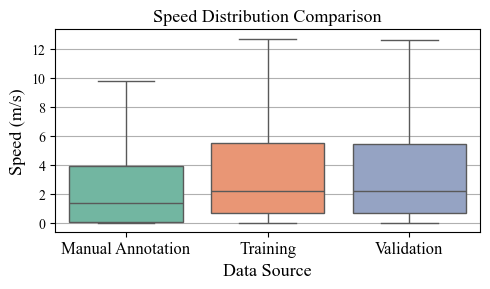

In [104]:

# box plot for speed distribution for vehicle_speed_train, vehicle_speed_val, speed_eva
# make it very bueatiful
plt.figure(figsize=(5,3))
plt.grid(axis = 'y')
sns.boxplot(data = [speed_eva,vehicle_speed_train,vehicle_speed_val],palette = 'Set2',showfliers = False)
plt.xticks([0,1,2],['Manual Annotation','Training','Validation'],fontsize = 12)
plt.ylabel('Speed (m/s)',fontsize = 13)
plt.xlabel('Data Source',fontsize = 13)
plt.title('Speed Distribution Comparison')
plt.tight_layout()

plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\dataset_speed_distribution_comparison.png',dpi = 300)
plt.show()

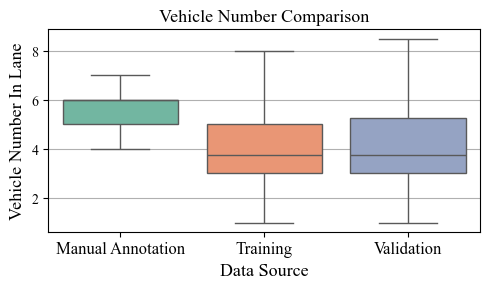

In [102]:

# box plot for speed distribution for vehicle_speed_train, vehicle_speed_val, speed_eva
# make it very bueatiful
plt.figure(figsize=(5,3))
plt.grid(axis = 'y')
sns.boxplot(data = [vehivle_num_eva,vehicle_nums_train,vehicle_nums_val],palette = 'Set2',showfliers = False)
plt.xticks([0,1,2],['Manual Annotation','Training','Validation'],fontsize = 12)
plt.ylabel('Vehicle Number In Lane',fontsize = 13)
plt.xlabel('Data Source',fontsize = 13)
plt.title('Vehicle Number Comparison',fontsize = 13)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\dataset_veh_distribution_comparison.png',dpi = 300)
plt.show()

In [577]:
batch_size = 1
total_tps, total_fps, total_fns = [], [], []
Iou_threshold = 0.8
for conf_thred in np.arange(0.2,0.9,0.05):
    val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
    count = 0
    total_tp, total_fp, total_fn = 0, 0, 0

    for val_ind in tqdm(range(len(val_dataset))):
        batch = val_dataset[val_ind]

        if count > 2000:
            break
        post_occ_X = batch['post_occ_X'].to(device)
        target = batch['target'].to(device)
        speed = batch['speed_target'].to(device)
        traj_id = batch['traj_id']
        time_space_diagram_input = post_occ_X.unsqueeze(0)
        traj_id = traj_id.cpu().numpy()
        with torch.no_grad():
            input_snippet = time_space_diagram_input
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
        trajs_label = get_trajctories_dict_from_Label_map(traj_id,time_span)
        # convert trajs_label to list
        trajs_label = [trajs_label[i] for i in trajs_label.keys()]
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        if TrajIoUMatrix.shape[1] == 0:
            # no detection
            total_fn += len(trajs_label)
            continue
        pred_index = TrajPortionMatrix.argmax(axis = 1)
        pred_IoU = []
        for i,j in enumerate(pred_index):
            pred_IoU.append(TrajIoUMatrix[i,j])
        pred_IoU = np.array(pred_IoU)
        # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
        tp, fp, fn = 0, 0, 0
        for i,j in enumerate(pred_index):
            if pred_IoU[i] >= Iou_threshold:
                tp += 1
            else:
                fn += 1

        for j in trajs_pred.keys():
            if trajs_pred[j][-1][1] > 100:
                continue
            if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
                continue
            if j not in pred_index:
                fp += 1
        # print(time_space_diagram_name)
        # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        total_tp += tp
        total_fp += fp
        total_fn += fn
        count += 1
    total_tps.append(total_tp)
    total_fps.append(total_fp)
    total_fns.append(total_fn)

df = pd.DataFrame({'ConfThred':np.arange(0.2,0.9,0.05),'TP':total_tps,'FP':total_fps,'FN':total_fns})
df['precision'] = df['TP'] / (df['TP'] + df['FP'])
df['recall'] = df['TP'] / (df['TP'] + df['FN'])
df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val_128.csv',index = False)
    

  0%|          | 88/246000 [00:01<1:14:25, 55.07it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
  2%|▏         | 4004/246000 [01:30<1:30:57, 44.35it/s]


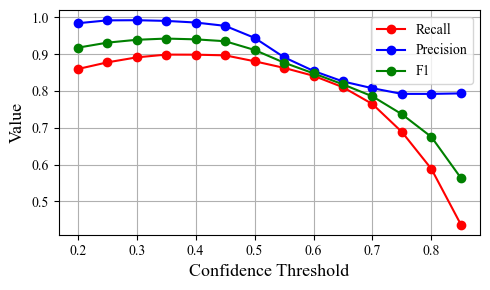

In [581]:
# plot precision recall curve and F1 score curve with different confidence threshold in same canvas, please make it beautiful
df_val = pd.read_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val.csv')
plt.figure(figsize=(5,3))
plt.grid()
plt.plot(df_val['ConfThred'],df_val['recall'],label = 'Recall', color = 'r', marker = 'o')
plt.plot(df_val['ConfThred'],df_val['precision'],label = 'Precision', color = 'b', marker = 'o')
plt.plot(df_val['ConfThred'],df_val['F1'],label = 'F1', color = 'g', marker = 'o')
plt.xlabel('Confidence Threshold',fontsize = 13)
plt.ylabel('Value',fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val_128.png',dpi = 300)
plt.show()

# Baseline Pure DBSCAN

In [557]:
total_tp, total_fp, total_fn = 0, 0, 0
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        total_fn += len(trajs_label)
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
    tp, fp, fn = 0, 0, 0
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold:
            tp += 1
        else:
            fn += 1

    for j in trajs_pred.keys():
        if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
            continue
        if j not in pred_index:
            fp += 1
    # print(time_space_diagram_name)
    # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    total_tp += tp
    total_fp += fp
    total_fn += fn

100%|██████████| 109/109 [00:02<00:00, 51.51it/s]


In [558]:
precision = total_tp / (total_tp + total_fp)
recall = total_tp / (total_tp + total_fn)
F1 = 2 * precision * recall / (precision + recall)

In [559]:
(total_fp,total_fn,total_tp,precision,recall,F1)

(76, 135, 460, 0.8582089552238806, 0.773109243697479, 0.8134394341290893)

In [170]:
# get vehicle number and speed in time_space_diagram_list
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
spatial_errors = []
speed_errors = []
speed_eva_window = 5
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold and len(trajs_pred[j]) > speed_eva_window:
            traj_label = trajs_label[i]
            traj_pred = trajs_pred[j]
            x_label = traj_label[:,1]
            x_pred = traj_pred[:,1]
            t_label = traj_label[:,0]
            t_pred = traj_pred[:,0]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            x_label_interp = interp_func(t_pred)
            sptial_error = np.abs(x_label_interp - x_pred) * 0.5
            spatial_errors.append(sptial_error)
            # calculate speed error
            speed_pred_curve = []
            speed_label_curve = []
            for k in range(len(sptial_error)-speed_eva_window):
                speed_pred = (x_pred[k+speed_eva_window] - x_pred[k])*0.5 / (speed_eva_window/10)
                speed_label = (x_label_interp[k+speed_eva_window] - x_label_interp[k])*0.5 / (speed_eva_window/10)
                speed_pred_curve.append(speed_pred)
                speed_label_curve.append(speed_label)
            speed_pred_curve = np.array(speed_pred_curve)
            speed_label_curve = np.array(speed_label_curve)
            speed_error = np.abs(speed_pred_curve - speed_label_curve)
            speed_errors.append(speed_error)

spatial_errors_DB = np.concatenate(spatial_errors)
speed_errors_DB = np.concatenate(speed_errors)          

100%|██████████| 109/109 [00:01<00:00, 65.91it/s]


In [561]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
count = 0
total_tp, total_fp, total_fn = 0, 0, 0

for val_ind in tqdm(range(len(val_dataset))):
    batch = val_dataset[val_ind]

    if count > 2000:
        break
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    time_space_diagram_input = post_occ_X.cpu().numpy()
    traj_id = traj_id.cpu().numpy()
    
    trajs_pred = get_trajs_from_LSTM_out(time_space_diagram_input,conf_thred = conf_thred,time_span = 100, lane_unit = 200,center=False)
    trajs_label = get_trajctories_dict_from_Label_map(traj_id,time_span)
    # convert trajs_label to list
    trajs_label = [trajs_label[i] for i in trajs_label.keys()]
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        total_fn += len(trajs_label)
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
    tp, fp, fn = 0, 0, 0
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold:
            tp += 1
        else:
            fn += 1

    for j in trajs_pred.keys():
        if trajs_pred[j][-1][1] > 100:
            continue
        if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
            continue
        if j not in pred_index:
            fp += 1
    # print(time_space_diagram_name)
    # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    total_tp += tp
    total_fp += fp
    total_fn += fn
    count += 1

  0%|          | 24/246000 [00:00<53:54, 76.05it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
  1%|          | 2001/246000 [00:36<1:13:59, 54.96it/s]


In [564]:
precision = total_tp / (total_tp + total_fp)
recall = total_tp / (total_tp + total_fn)
F1 = 2 * precision * recall / (precision + recall)

In [565]:
(total_fp,total_fn,total_tp,precision,recall,F1)

(2721,
 6684,
 1396,
 0.3390818557201846,
 0.17277227722772276,
 0.22890874805279987)

# Kalman Filter

In [566]:
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
from filterpy.common import Q_discrete_white_noise

total_tp, total_fp, total_fn = 0, 0, 0
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    Labels = db.fit_predict(time_space_diagram_input> 0, time_space_diagram_input > 0)

    trajs_pred = get_trajs_from_Kalman_out(Labels,time_span)
    
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        total_fn += len(trajs_label)
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
    tp, fp, fn = 0, 0, 0
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold:
            tp += 1
        else:
            fn += 1

    for j in trajs_pred.keys():
        if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
            continue
        if j not in pred_index:
            fp += 1
    # print(time_space_diagram_name)
    # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    total_tp += tp
    total_fp += fp
    total_fn += fn


100%|██████████| 109/109 [00:04<00:00, 25.71it/s]


In [569]:
recall = total_tp / (total_tp + total_fn)
precision = total_tp / (total_tp + total_fp)
F1 = 2 * precision * recall / (precision + recall)
(total_fp,total_fn,total_tp,precision,recall,F1)

(46, 155, 440, 0.9053497942386831, 0.7394957983193278, 0.8140610545790935)

In [175]:
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
from filterpy.common import Q_discrete_white_noise
# get vehicle number and speed in time_space_diagram_list
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
spatial_errors = []
speed_errors = []
speed_eva_window = 5
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    time_space_diagram_input = time_space_diagram_raw > 100
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    Labels = db.fit_predict(time_space_diagram_input> 0, time_space_diagram_input > 0)

    trajs_pred = get_trajs_from_Kalman_out(Labels,time_span)
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold and len(trajs_pred[j]) > speed_eva_window:
            traj_label = trajs_label[i]
            traj_pred = trajs_pred[j]
            x_label = traj_label[:,1]
            x_pred = traj_pred[:,1]
            t_label = traj_label[:,0]
            t_pred = traj_pred[:,0]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            x_label_interp = interp_func(t_pred)
            sptial_error = np.abs(x_label_interp - x_pred) * 0.5
            spatial_errors.append(sptial_error)
            # calculate speed error
            speed_pred_curve = []
            speed_label_curve = []
            for k in range(len(sptial_error)-speed_eva_window):
                speed_pred = (x_pred[k+speed_eva_window] - x_pred[k])*0.5 / (speed_eva_window/10)
                speed_label = (x_label_interp[k+speed_eva_window] - x_label_interp[k])*0.5 / (speed_eva_window/10)
                speed_pred_curve.append(speed_pred)
                speed_label_curve.append(speed_label)
            speed_pred_curve = np.array(speed_pred_curve)
            speed_label_curve = np.array(speed_label_curve)
            speed_error = np.abs(speed_pred_curve - speed_label_curve)
            speed_errors.append(speed_error)

spatial_errors_KF = np.concatenate(spatial_errors)
speed_errors_KF = np.concatenate(speed_errors)          

100%|██████████| 109/109 [00:03<00:00, 29.62it/s]


In [570]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
count = 0
total_tp, total_fp, total_fn = 0, 0, 0

for val_ind in tqdm(range(len(val_dataset))):
    batch = val_dataset[val_ind]

    if count > 2000:
        break
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    time_space_diagram_input = post_occ_X.cpu().numpy()
    traj_id = traj_id.cpu().numpy()
    trajs_label = get_trajctories_dict_from_Label_map(traj_id,time_span)
    # convert trajs_label to list
    trajs_label = [trajs_label[i] for i in trajs_label.keys()]
    time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
    Labels = db.fit_predict(time_space_diagram_input> 0, time_space_diagram_input > 0)

    trajs_pred = get_trajs_from_Kalman_out(Labels,time_span)
    # exclude empty trajs in trajs_pred
    trajs_pred = {key:trajs_pred[key] for key in trajs_pred.keys() if len(trajs_pred[key]) > 0}
    TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
    if TrajIoUMatrix.shape[1] == 0:
        # no detection
        total_fn += len(trajs_label)
        continue
    pred_index = TrajPortionMatrix.argmax(axis = 1)
    pred_IoU = []
    for i,j in enumerate(pred_index):
        pred_IoU.append(TrajIoUMatrix[i,j])
    pred_IoU = np.array(pred_IoU)
    # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
    tp, fp, fn = 0, 0, 0
    for i,j in enumerate(pred_index):
        if pred_IoU[i] >= Iou_threshold:
            tp += 1
        else:
            fn += 1

    for j in trajs_pred.keys():
        if trajs_pred[j][-1][1] > 100:
            continue
        if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
            continue
        if j not in pred_index:
            fp += 1
    # print(time_space_diagram_name)
    # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    total_tp += tp
    total_fp += fp
    total_fn += fn
    count += 1

  0%|          | 25/246000 [00:00<1:42:15, 40.09it/s]c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
  1%|          | 2011/246000 [01:01<2:05:20, 32.44it/s]


In [572]:
precision = total_tp / (total_tp + total_fp)
recall = total_tp / (total_tp + total_fn)
F1 = 2 * precision * recall / (precision + recall)
(total_fp,total_fn,total_tp,precision,recall,F1)

(1695,
 7108,
 1077,
 0.38852813852813856,
 0.13158216249236407,
 0.19658665693164187)

# Training Curve

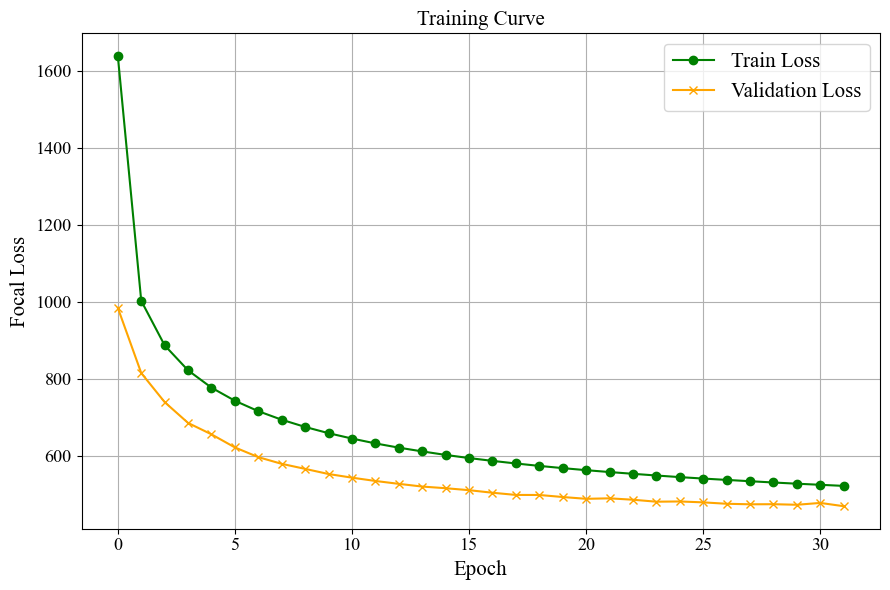

In [612]:
import json
curve_info_path = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\models\train_3\training_curve.json'
with open(curve_info_path) as f:
    curve_info = json.load(f)
train_loss = curve_info['train_loss']
val_loss = curve_info['val_loss']
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
plt.figure(figsize=(9,6))
plt.grid()
plt.plot(train_loss,label = 'Train Loss',color = 'green', marker = 'o')
plt.plot(val_loss,label = 'Validation Loss',color = 'orange', marker = 'x')
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('Focal Loss',fontsize = 15)
plt.title('Training Curve',fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\training_curve.png',dpi = 300)
plt.show()

## Error Distribution

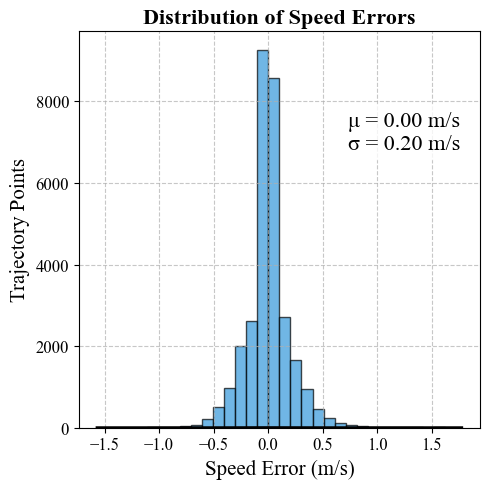

In [242]:
# Calculate statistics
speed_errors = speed_errors_LSTM
mean = np.mean(speed_errors)
std = np.std(speed_errors)

# Set up the plot
plt.figure(figsize=(5, 5))
# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
# Plot histogram
n, bins, patches = plt.hist(speed_errors, bins=30, alpha=0.7, color='#3498db', edgecolor='black')
# Plot Gaussian curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian Fit')
# Shade area within 1 standard deviation
# plt.fill_between(x, p, where=(x >= mean - std) & (x <= mean + std), 
#                  color='gray', alpha=0.3, label='1σ Range')
# Formatting
plt.title('Distribution of Speed Errors', fontweight='bold', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Speed Error (m/s)', fontsize=15)
plt.ylabel('Trajectory Points', fontsize=15)
# plt.xlim(0, 0.8)
# Add text box with statistics
stats_text = f'μ = {mean:.2f} m/s\nσ = {std:.2f} m/s'
plt.text(0.95, 0.80, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=16)
# Adjust legend position to avoid overlap
# plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save the figure
plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\speed_error_hist.png', dpi=300, bbox_inches='tight')
plt.show()

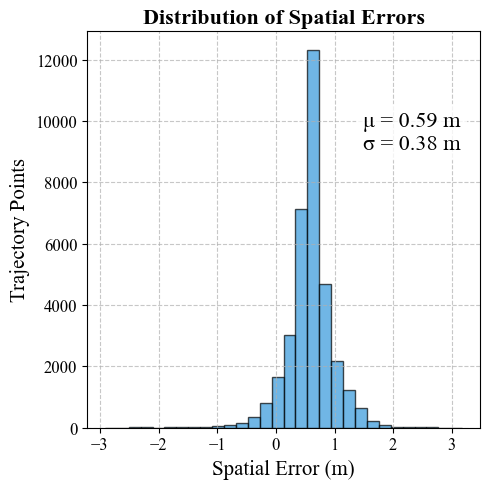

In [243]:
# Calculate statistics
sptial_errors = spatial_errors_LSTM
mean = np.mean(sptial_errors)
std = np.std(sptial_errors)

# Set up the plot
plt.figure(figsize=(5, 5))
# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
# Plot histogram
n, bins, patches = plt.hist(sptial_errors, bins=30, alpha=0.7, color='#3498db', edgecolor='black')
# Plot Gaussian curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
# plt.plot(x, p, 'k', linewidth=2, label='Gaussian Fit')
# Shade area within 1 standard deviation
# plt.fill_between(x, p, where=(x >= mean - std) & (x <= mean + std), 
#                  color='gray', alpha=0.3, label='1σ Range')
# Formatting
plt.title('Distribution of Spatial Errors', fontweight='bold', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Spatial Error (m)', fontsize=15)
plt.ylabel('Trajectory Points', fontsize=15)
# plt.xlim(0, 1)
# Add text box with statistics
stats_text = f'μ = {mean:.2f} m\nσ = {std:.2f} m'
plt.text(0.95, 0.80, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=16)
# Adjust legend position to avoid overlap
# plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save the figure
plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\spatial_error_hist.png', dpi=300, bbox_inches='tight')
plt.show()